## Projection rectification using $n > 4$ points
### Theory
Recall in projection_rectification we need 4 points to perform the rectification and work out the matrix $H$. Each point pair $x_i, x_i'$ gives two equations: 
$$
 \begin{bmatrix}
        0^T & -w_i' \mathbf{x_i^T} & y_i'\mathbf{x_i^T}  \\
        -w_i' \mathbf{x_i^T} & 0^T & -x_i'\mathbf{x_i^T} \\
        -y_i'\mathbf{x_i^T} & x_i'\mathbf{x_i^T} & 0^T
\end{bmatrix}_{3 \times 9} h = \mathbf{0}
$$
and so for 4 points there are 8 equations to solve the 8 parameters of the matrix $H$. But measurements are never perfect, and the task is to use more points to achieve a better mapping.

Having more than 4 points = having more than 8 equations for $Ah = 0$. So there is no exact solution for $h$ since it has only 8 parameters. We need to obtain the best approximate solution. 

#### Direct linear transform
The simplest way is to solve for a solution $h$ that *minimizes $||Ah||$*, with the constraint $||h|| = 1$ to avoid $h = 0$.
 
To do so: 
- Get the *Singular Value Decomposition* of A: $A = UDV^T$
- $D$ is a diagonal matrix. Reorder the diagonal from high to low, doing the same with $V$
- $h$ is the last column of $V$ . In other words, $h$ is the column vector of $V$ corresponding to the minimum entry on the diagonal of $D$.
*Don't make the mistake of saying h is the column vector of $V^T$!*

How to do the SVD is given in the supplementary note.
Note that this technique is used even in the case of 4 points, as it is less prone to the "setting last parameter = 1" kind of error.

#### Minimizing cost functions iteratively

Some other cost functions include: 
- One way geometric error: $distance(x_i', Hx_i)$
- Two way geometric error: $distance(x_i, H^-1x'_i) + distance(x_i', Hx_i)$
- Reprojection error
- Maximum Likelyhood error

In many cases these cost functions reduce down to one another and even down to $||Ah||$, depending on the nature of the transformation $H$. 

#### An example with minimizing $||Ah||$

(480, 480, 3)


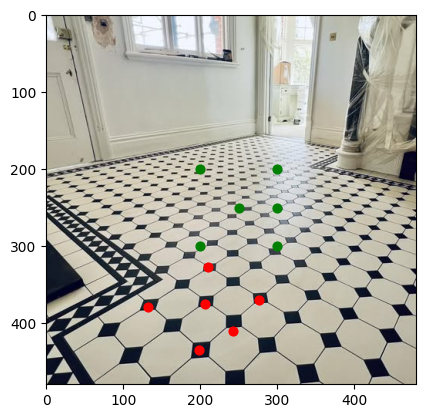

In [47]:
%matplotlib inline

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Load image, put on plot
import matplotlib.pyplot as plt
import numpy as np

image = plt.imread('../images/floor.jpg')
# Display the image

# selecting 4 points, put them on the image
x = np.array([[132,379], [198, 435], [276,370], [210, 327], [206,375], [242,410]])
x_coords, y_coords = zip(*x)


# And the corresponding points where we want them to be after the distortion undo
x_prime = np.array([[200, 300], [300, 300], [300, 200], [200,200], [250,250], [300,250]])


xp_coords, yp_coords = zip(*x_prime)

fig, ax = plt.subplots()
ax.imshow(image)
print(image.shape)
ax.scatter(x_coords, y_coords, color="red", s=40)
ax.scatter(xp_coords, yp_coords, color="green", s=40)

In [48]:
from utils.homography.get_matrix import get_A

A = get_A(x, x_prime)

# do SVD on A 
U, D, VT = np.linalg.svd(A) 

# get the index of the smallest value in D
ind = np.argmin(D)
H = VT.T[:, ind].reshape((3,3))

In [49]:
H

array([[-1.30020214e-03, -2.59532749e-03,  8.98643543e-01],
       [ 5.85752249e-04, -2.39164209e-03,  4.38662440e-01],
       [-1.21859210e-06, -4.93624310e-06,  7.45924176e-04]])

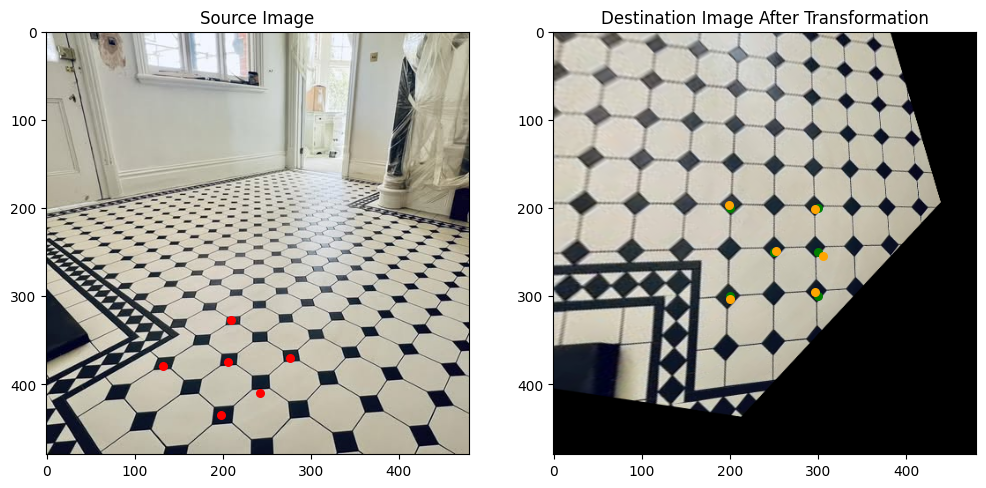

In [50]:
# Apply H on the image

%matplotlib inline
from scipy import ndimage as ndi
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import ProjectiveTransform, warp
import numpy as np

im_src = imread('../images/floor.jpg')
height, width, dim = im_src.shape
im_dst = np.zeros((height, width, dim))

# funny perk of warp: it applies inverse of H to the image
H_inv = np.linalg.inv(H)

im_dst = warp(im_src, H_inv, output_shape=(height, width))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(im_src)
x_coords, y_coords = zip(*x)
plt.scatter(x_coords, y_coords, s=30, color="red")
plt.title('Source Image')
plt.subplot(122)
plt.imshow(im_dst)

# Where I want the points to go
x_coords, y_coords = zip(*x_prime)
plt.scatter(x_coords, y_coords, s=30, color="green")

# Where they actually are
x_primehat = H @ np.hstack((x, np.ones((x.shape[0], 1)))).T
x_primehat = x_primehat.T * (1/x_primehat.T[:, -1]).reshape((-1,1))
x_primehat = x_primehat[:, :-1]
x_coords, y_coords = zip(*x_primehat)
plt.scatter(x_coords, y_coords, s=30, color="orange")
plt.title('Destination Image After Transformation')
plt.show()

The points are pretty damn precise and does not show a large error! In fact, I have intentionally chosen a point that is erroneous. 